In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt
import seaborn as sns

from linearmodels.iv import IV2SLS

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
seed: int = sum(map(ord, "double_ml_bart"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
random_seed_int: int = rng.integers(low=0, high=100, size=1).item()

In [3]:
root_path = "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/"
data_path = os.path.join(root_path, "app_engagement_push.csv")

df = pd.read_csv(data_path)

n = df.shape[0]

df.head()

,in_app_purchase,push_assigned,push_delivered
0,47,1,1
1,43,1,0
2,51,1,1
3,49,0,0
4,79,0,0


In [4]:
formula = "in_app_purchase ~ 1 + [push_delivered ~ push_assigned]"
iv = IV2SLS.from_formula(formula=formula, data=df).fit()
iv.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
Intercept,69.292,0.3624,191.22,0.0000,68.581,70.002
push_delivered,3.2938,0.7165,4.5974,0.0000,1.8896,4.6981


In [5]:
y = df["in_app_purchase"].to_numpy()
t = df["push_delivered"].to_numpy()
z = df["push_assigned"].to_numpy()

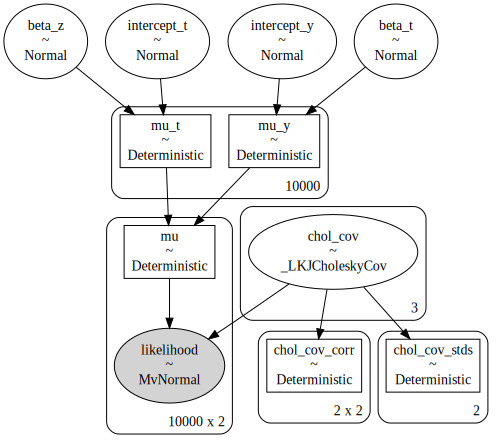

In [6]:
with pm.Model() as model:
    intercept_y = pm.Normal(name="intercept_y", mu=0, sigma=1)
    intercept_t = pm.Normal(name="intercept_t", mu=0, sigma=1)
    beta_t = pm.Normal(name="beta_t", mu=0, sigma=1)
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=1)
    sd_dist = pm.HalfCauchy.dist(beta=2, shape=2)
    chol, corr, sigmas = pm.LKJCholeskyCov(name="chol_cov", eta=2, n=2, sd_dist=sd_dist)
    
    mu_y = pm.Deterministic(name="mu_y", var=beta_t * t + intercept_y)
    mu_t = pm.Deterministic(name="mu_t", var=beta_z * z + intercept_t)
    mu = pm.Deterministic(name="mu", var=pt.stack(tensors=(mu_y, mu_t), axis=1))
    
    likelihood = pm.MvNormal(
        name="likelihood",
        mu=mu,
        chol=chol,
        observed=np.stack(arrays=(y, t), axis=1),
        shape=(n, 2),
    )

pm.model_to_graphviz(model=model)


In [7]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=2_000, chains=4)
    # posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:05.604551
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:30.109993
Transforming variables...
Transformation time =  0:00:03.048211


In [8]:
var_names = ["beta_t", "beta_z", "intercept_y", "intercept_t"]


az.summary(data=idata, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_t,9.406,0.565,8.372,10.475,0.008,0.006,5021.0,5681.0,1.0
beta_z,0.730,0.006,0.718,0.742,0.000,0.000,6908.0,6255.0,1.0
intercept_y,62.985,0.312,62.379,63.563,0.004,0.003,5813.0,5912.0,1.0
intercept_t,-0.018,0.004,-0.027,-0.010,0.000,0.000,6938.0,6530.0,1.0


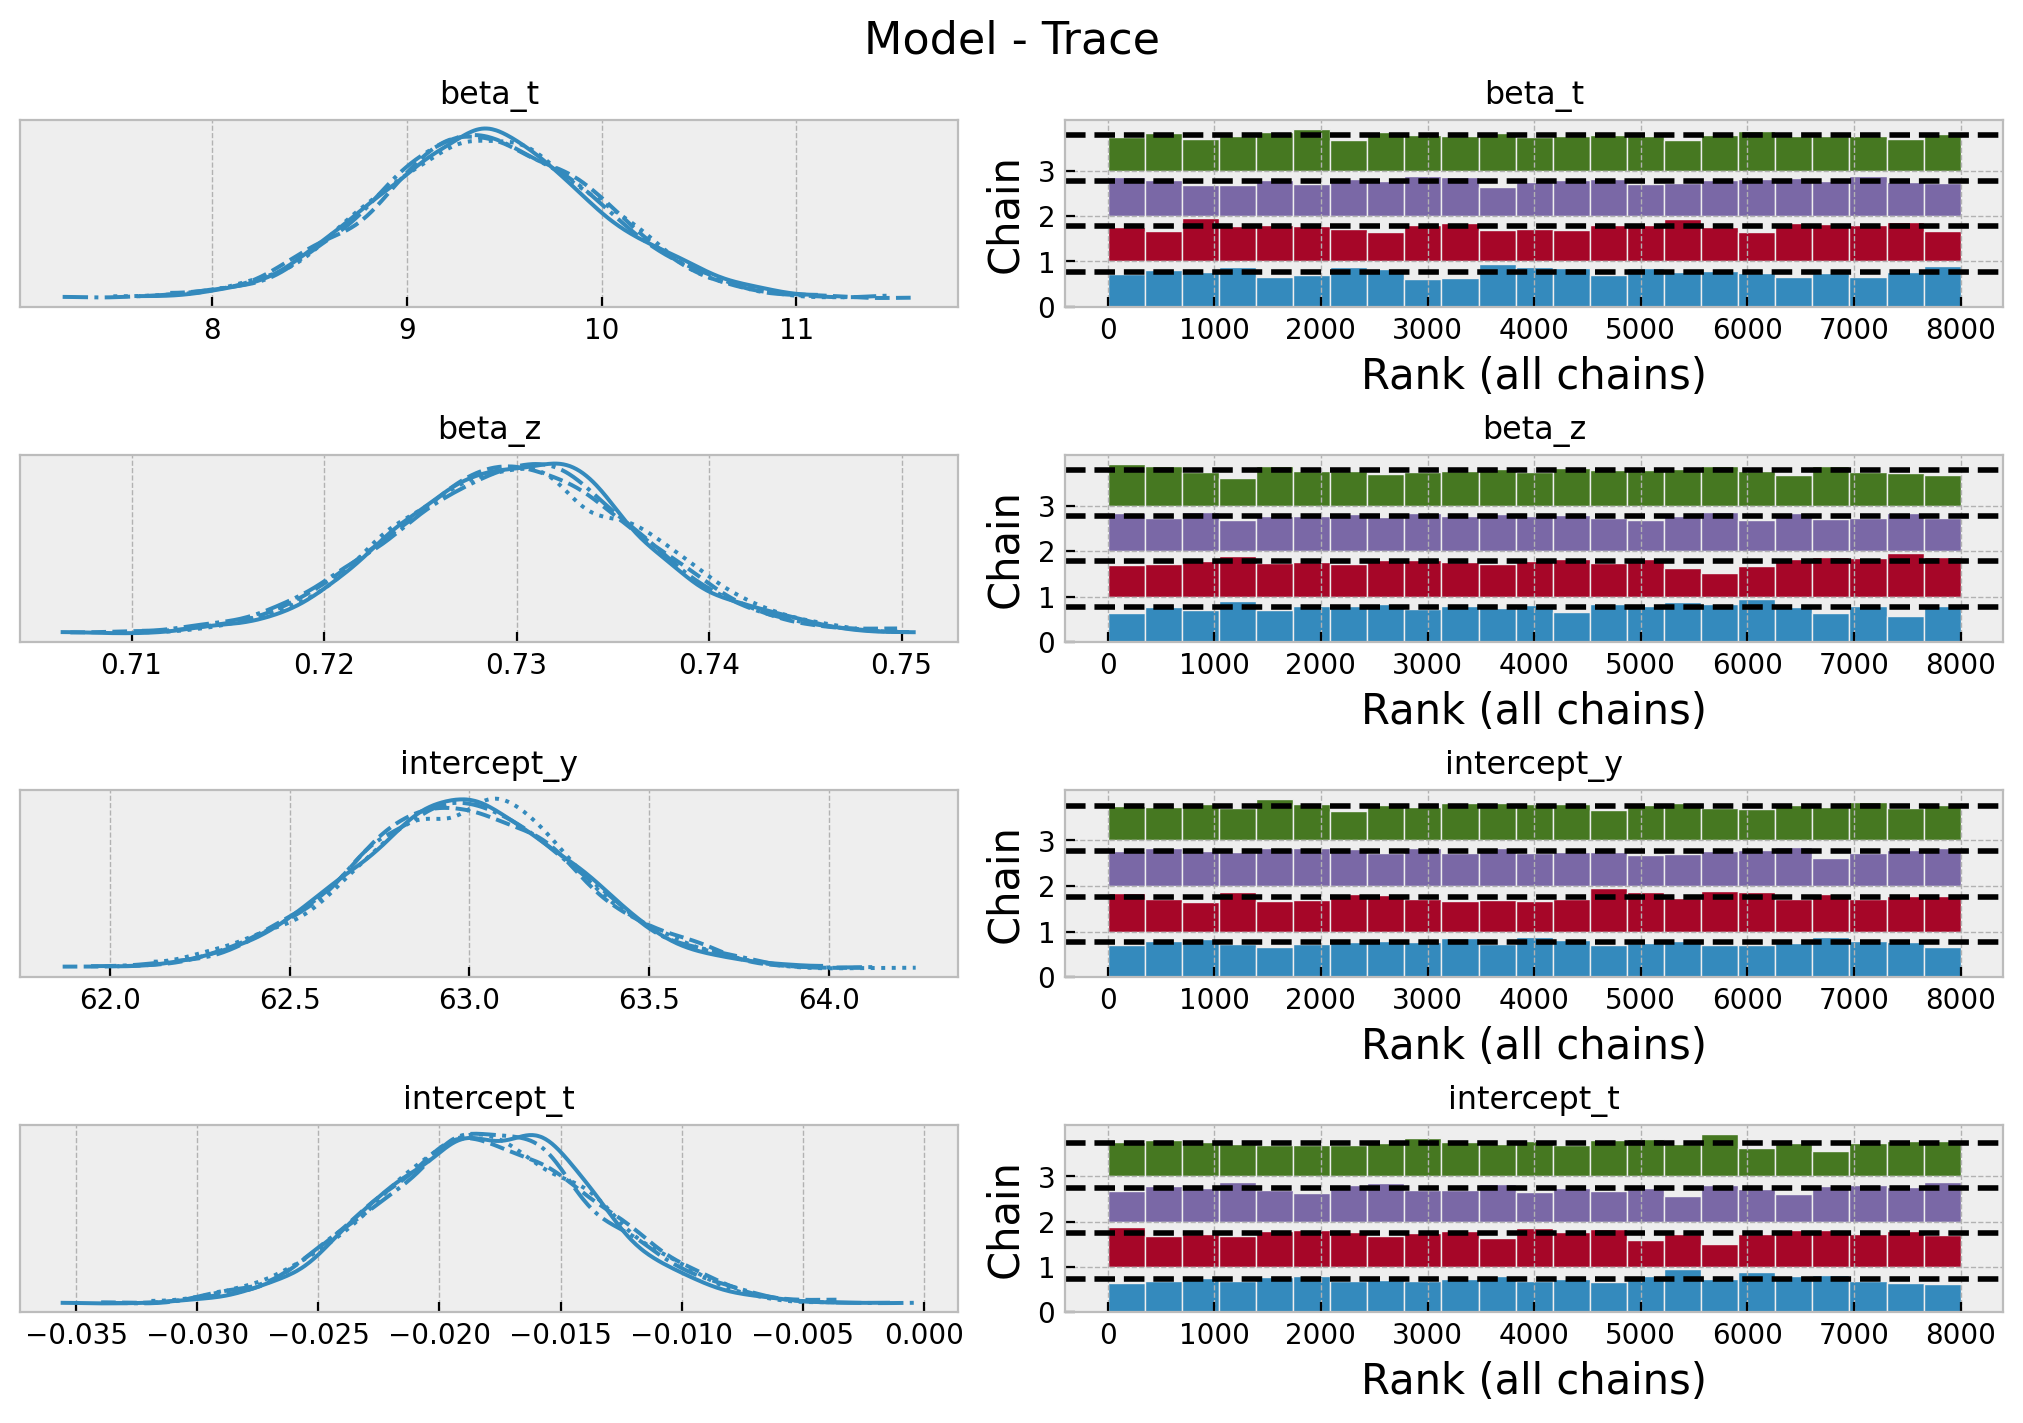

In [9]:

axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16);

In [10]:
az.summary(data=idata, var_names=["chol_cov_corr"])

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.0,0.0,8000.0,8000.0,NaN
"chol_cov_corr[0, 1]",0.232,0.012,0.211,0.255,0.0,0.0,6392.0,6326.0,1.0
"chol_cov_corr[1, 0]",0.232,0.012,0.211,0.255,0.0,0.0,6392.0,6326.0,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.0,0.0,7528.0,7303.0,1.0
